#Preamble and Imports

In [1]:
import torch
import torch.nn as nn
from torchvision import transforms, datasets
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm
import requests
import os
import tarfile

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import confusion_matrix, adjusted_rand_score, adjusted_mutual_info_score
from sklearn.pipeline import Pipeline
from sklearn.base import TransformerMixin

#New 
from sklearn.decomposition import TruncatedSVD
from sklearn.cluster import AgglomerativeClustering
!pip install umap-learn
#import umap-learn
import umap
!pip install hdbscan
import hdbscan
from sklearn.datasets import make_blobs
from sklearn.metrics.cluster import adjusted_rand_score
from sklearn.metrics.cluster import rand_score
from sklearn.model_selection import train_test_split
np.random.seed(0)
import numpy as np
import sklearn
from sklearn.manifold import TSNE
from google.colab import drive
drive.mount('/content/drive')

     |████████████████████████████████| 86 kB 3.6 MB/s 
     |████████████████████████████████| 1.1 MB 11.7 MB/s 
  Created wheel for umap-learn: filename=umap_learn-0.5.2-py3-none-any.whl size=82708 sha256=60462d74cd1f5bf320b5ce2322174756411052ffcdf7c56b8ddad305c55ee64a
  Stored in directory: /root/.cache/pip/wheels/84/1b/c6/aaf68a748122632967cef4dffef68224eb16798b6793257d82
  Created wheel for pynndescent: filename=pynndescent-0.5.6-py3-none-any.whl size=53943 sha256=48348748eab96072b16e511243627a00f1168f595854d7ae79db3310d742fa06
  Stored in directory: /root/.cache/pip/wheels/03/f1/56/f80d72741e400345b5a5b50ec3d929aca581bf45e0225d5c50
Successfully built umap-learn pynndescent
     |████████████████████████████████| 6.4 MB 7.0 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for hdbscan: filename=hdbscan-0.8.27-cp37-cp37m-linux_x86_64.whl size=2311897 sha256=f785c222f1621a9a71116849ab37

# Flowers Dataset and VGG Features

![image.png](attachment:image.png)

In [2]:
filename = './flowers_features_and_labels.npz'

if os.path.exists(filename):
    file = np.load(filename)
    f_all, y_all = file['f_all'], file['y_all']

else:
    if not os.path.exists('./flower_photos'):
        # download the flowers dataset and extract its images
        url = 'http://download.tensorflow.org/example_images/flower_photos.tgz'
        with open('./flower_photos.tgz', 'wb') as file:
            file.write(requests.get(url).content)
        with tarfile.open('./flower_photos.tgz') as file:
            file.extractall('./')
        os.remove('./flower_photos.tgz')

    class FeatureExtractor(nn.Module):
        def __init__(self):
            super().__init__()

            vgg = torch.hub.load('pytorch/vision:v0.10.0', 'vgg16', pretrained=True)

            # Extract VGG-16 Feature Layers
            self.features = list(vgg.features)
            
            self.features = nn.Sequential(*self.features)
            # Extract VGG-16 Average Pooling Layer
            self.pooling = vgg.avgpool
            # Convert the image into one-dimensional vector
            self.flatten = nn.Flatten()
            # Extract the first part of fully-connected layer from VGG16
            self.fc = vgg.classifier[0]

        def forward(self, x):
            # It will take the input 'x' until it returns the feature vector called 'out'
            np.shape(x)
            out = self.features(x)
            print(out.shape)
            out = self.pooling(out)
            print(out.shape)
            out = self.flatten(out)
            print(out.shape)
            out = self.fc(out) 
            print(out.shape)
            return out 

    # Initialize the model
    assert torch.cuda.is_available()
    feature_extractor = FeatureExtractor().cuda().eval()

    dataset = datasets.ImageFolder(root='./flower_photos',
                                   transform=transforms.Compose([transforms.Resize(224),
                                                                 transforms.CenterCrop(224),
                                                                 transforms.ToTensor(),
                                                                 transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])]))
    dataloader = DataLoader(dataset, batch_size=64, shuffle=True)

    # Extract features and store them on disk
    f_all, y_all = np.zeros((0, 4096)), np.zeros((0,))
    for x, y in tqdm(dataloader):
        print("In here")
        print(x.shape)
        with torch.no_grad():
            f_all = np.vstack([f_all, feature_extractor(x.cuda()).cpu()])
            y_all = np.concatenate([y_all, y])
    np.savez(filename, f_all=f_all, y_all=y_all)

Downloading: "https://github.com/pytorch/vision/archive/v0.10.0.zip" to /root/.cache/torch/hub/v0.10.0.zip
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

  0%|          | 0/58 [00:00<?, ?it/s]

In here
torch.Size([64, 3, 224, 224])
torch.Size([64, 512, 7, 7])
torch.Size([64, 512, 7, 7])
torch.Size([64, 25088])


  2%|▏         | 1/58 [00:01<01:18,  1.37s/it]

torch.Size([64, 4096])
In here
torch.Size([64, 3, 224, 224])
torch.Size([64, 512, 7, 7])
torch.Size([64, 512, 7, 7])
torch.Size([64, 25088])
torch.Size([64, 4096])


  3%|▎         | 2/58 [00:02<00:58,  1.05s/it]

In here
torch.Size([64, 3, 224, 224])
torch.Size([64, 512, 7, 7])
torch.Size([64, 512, 7, 7])
torch.Size([64, 25088])
torch.Size([64, 4096])


  5%|▌         | 3/58 [00:03<00:52,  1.06it/s]

In here
torch.Size([64, 3, 224, 224])
torch.Size([64, 512, 7, 7])
torch.Size([64, 512, 7, 7])
torch.Size([64, 25088])
torch.Size([64, 4096])


  7%|▋         | 4/58 [00:03<00:47,  1.13it/s]

In here
torch.Size([64, 3, 224, 224])
torch.Size([64, 512, 7, 7])
torch.Size([64, 512, 7, 7])
torch.Size([64, 25088])
torch.Size([64, 4096])


  9%|▊         | 5/58 [00:04<00:45,  1.18it/s]

In here
torch.Size([64, 3, 224, 224])
torch.Size([64, 512, 7, 7])
torch.Size([64, 512, 7, 7])
torch.Size([64, 25088])
torch.Size([64, 4096])


 10%|█         | 6/58 [00:05<00:42,  1.22it/s]

In here
torch.Size([64, 3, 224, 224])
torch.Size([64, 512, 7, 7])
torch.Size([64, 512, 7, 7])
torch.Size([64, 25088])
torch.Size([64, 4096])


 12%|█▏        | 7/58 [00:06<00:41,  1.23it/s]

In here
torch.Size([64, 3, 224, 224])
torch.Size([64, 512, 7, 7])
torch.Size([64, 512, 7, 7])
torch.Size([64, 25088])
torch.Size([64, 4096])


 14%|█▍        | 8/58 [00:06<00:40,  1.23it/s]

In here
torch.Size([64, 3, 224, 224])
torch.Size([64, 512, 7, 7])
torch.Size([64, 512, 7, 7])
torch.Size([64, 25088])
torch.Size([64, 4096])


 16%|█▌        | 9/58 [00:07<00:39,  1.23it/s]

In here
torch.Size([64, 3, 224, 224])
torch.Size([64, 512, 7, 7])
torch.Size([64, 512, 7, 7])
torch.Size([64, 25088])
torch.Size([64, 4096])


 17%|█▋        | 10/58 [00:08<00:39,  1.22it/s]

In here
torch.Size([64, 3, 224, 224])
torch.Size([64, 512, 7, 7])
torch.Size([64, 512, 7, 7])
torch.Size([64, 25088])
torch.Size([64, 4096])


 19%|█▉        | 11/58 [00:09<00:37,  1.24it/s]

In here
torch.Size([64, 3, 224, 224])
torch.Size([64, 512, 7, 7])
torch.Size([64, 512, 7, 7])
torch.Size([64, 25088])
torch.Size([64, 4096])


 21%|██        | 12/58 [00:10<00:36,  1.26it/s]

In here
torch.Size([64, 3, 224, 224])
torch.Size([64, 512, 7, 7])
torch.Size([64, 512, 7, 7])
torch.Size([64, 25088])
torch.Size([64, 4096])


 22%|██▏       | 13/58 [00:10<00:35,  1.26it/s]

In here
torch.Size([64, 3, 224, 224])
torch.Size([64, 512, 7, 7])
torch.Size([64, 512, 7, 7])
torch.Size([64, 25088])
torch.Size([64, 4096])


 24%|██▍       | 14/58 [00:11<00:34,  1.26it/s]

In here
torch.Size([64, 3, 224, 224])
torch.Size([64, 512, 7, 7])
torch.Size([64, 512, 7, 7])
torch.Size([64, 25088])
torch.Size([64, 4096])


 26%|██▌       | 15/58 [00:12<00:34,  1.25it/s]

In here
torch.Size([64, 3, 224, 224])
torch.Size([64, 512, 7, 7])
torch.Size([64, 512, 7, 7])
torch.Size([64, 25088])
torch.Size([64, 4096])


 28%|██▊       | 16/58 [00:13<00:33,  1.26it/s]

In here
torch.Size([64, 3, 224, 224])
torch.Size([64, 512, 7, 7])
torch.Size([64, 512, 7, 7])
torch.Size([64, 25088])
torch.Size([64, 4096])


 29%|██▉       | 17/58 [00:14<00:32,  1.26it/s]

In here
torch.Size([64, 3, 224, 224])
torch.Size([64, 512, 7, 7])
torch.Size([64, 512, 7, 7])
torch.Size([64, 25088])
torch.Size([64, 4096])


 31%|███       | 18/58 [00:14<00:31,  1.26it/s]

In here
torch.Size([64, 3, 224, 224])
torch.Size([64, 512, 7, 7])
torch.Size([64, 512, 7, 7])
torch.Size([64, 25088])
torch.Size([64, 4096])


 33%|███▎      | 19/58 [00:15<00:31,  1.25it/s]

In here
torch.Size([64, 3, 224, 224])
torch.Size([64, 512, 7, 7])
torch.Size([64, 512, 7, 7])
torch.Size([64, 25088])
torch.Size([64, 4096])


 34%|███▍      | 20/58 [00:16<00:30,  1.23it/s]

In here
torch.Size([64, 3, 224, 224])
torch.Size([64, 512, 7, 7])
torch.Size([64, 512, 7, 7])
torch.Size([64, 25088])
torch.Size([64, 4096])


 36%|███▌      | 21/58 [00:17<00:30,  1.23it/s]

In here
torch.Size([64, 3, 224, 224])
torch.Size([64, 512, 7, 7])
torch.Size([64, 512, 7, 7])
torch.Size([64, 25088])
torch.Size([64, 4096])


 38%|███▊      | 22/58 [00:18<00:29,  1.24it/s]

In here
torch.Size([64, 3, 224, 224])
torch.Size([64, 512, 7, 7])
torch.Size([64, 512, 7, 7])
torch.Size([64, 25088])
torch.Size([64, 4096])


 40%|███▉      | 23/58 [00:19<00:28,  1.23it/s]

In here
torch.Size([64, 3, 224, 224])
torch.Size([64, 512, 7, 7])
torch.Size([64, 512, 7, 7])
torch.Size([64, 25088])
torch.Size([64, 4096])


 41%|████▏     | 24/58 [00:20<00:29,  1.16it/s]

In here
torch.Size([64, 3, 224, 224])
torch.Size([64, 512, 7, 7])
torch.Size([64, 512, 7, 7])
torch.Size([64, 25088])
torch.Size([64, 4096])


 43%|████▎     | 25/58 [00:20<00:29,  1.12it/s]

In here
torch.Size([64, 3, 224, 224])
torch.Size([64, 512, 7, 7])
torch.Size([64, 512, 7, 7])
torch.Size([64, 25088])
torch.Size([64, 4096])


 45%|████▍     | 26/58 [00:21<00:26,  1.20it/s]

In here
torch.Size([64, 3, 224, 224])
torch.Size([64, 512, 7, 7])
torch.Size([64, 512, 7, 7])
torch.Size([64, 25088])
torch.Size([64, 4096])


 47%|████▋     | 27/58 [00:22<00:23,  1.32it/s]

In here
torch.Size([64, 3, 224, 224])
torch.Size([64, 512, 7, 7])
torch.Size([64, 512, 7, 7])
torch.Size([64, 25088])
torch.Size([64, 4096])


 48%|████▊     | 28/58 [00:22<00:21,  1.39it/s]

In here
torch.Size([64, 3, 224, 224])
torch.Size([64, 512, 7, 7])
torch.Size([64, 512, 7, 7])
torch.Size([64, 25088])
torch.Size([64, 4096])


 50%|█████     | 29/58 [00:23<00:19,  1.45it/s]

In here
torch.Size([64, 3, 224, 224])
torch.Size([64, 512, 7, 7])
torch.Size([64, 512, 7, 7])
torch.Size([64, 25088])
torch.Size([64, 4096])


 52%|█████▏    | 30/58 [00:24<00:18,  1.50it/s]

In here
torch.Size([64, 3, 224, 224])
torch.Size([64, 512, 7, 7])
torch.Size([64, 512, 7, 7])
torch.Size([64, 25088])
torch.Size([64, 4096])


 53%|█████▎    | 31/58 [00:24<00:17,  1.53it/s]

In here
torch.Size([64, 3, 224, 224])
torch.Size([64, 512, 7, 7])
torch.Size([64, 512, 7, 7])
torch.Size([64, 25088])
torch.Size([64, 4096])


 55%|█████▌    | 32/58 [00:25<00:16,  1.57it/s]

In here
torch.Size([64, 3, 224, 224])
torch.Size([64, 512, 7, 7])
torch.Size([64, 512, 7, 7])
torch.Size([64, 25088])
torch.Size([64, 4096])


 57%|█████▋    | 33/58 [00:25<00:15,  1.57it/s]

In here
torch.Size([64, 3, 224, 224])
torch.Size([64, 512, 7, 7])
torch.Size([64, 512, 7, 7])
torch.Size([64, 25088])
torch.Size([64, 4096])


 59%|█████▊    | 34/58 [00:26<00:15,  1.58it/s]

In here
torch.Size([64, 3, 224, 224])
torch.Size([64, 512, 7, 7])
torch.Size([64, 512, 7, 7])
torch.Size([64, 25088])
torch.Size([64, 4096])


 60%|██████    | 35/58 [00:27<00:14,  1.59it/s]

In here
torch.Size([64, 3, 224, 224])
torch.Size([64, 512, 7, 7])
torch.Size([64, 512, 7, 7])
torch.Size([64, 25088])
torch.Size([64, 4096])


 62%|██████▏   | 36/58 [00:27<00:14,  1.57it/s]

In here
torch.Size([64, 3, 224, 224])
torch.Size([64, 512, 7, 7])
torch.Size([64, 512, 7, 7])
torch.Size([64, 25088])
torch.Size([64, 4096])


 64%|██████▍   | 37/58 [00:28<00:13,  1.59it/s]

In here
torch.Size([64, 3, 224, 224])
torch.Size([64, 512, 7, 7])
torch.Size([64, 512, 7, 7])
torch.Size([64, 25088])
torch.Size([64, 4096])


 66%|██████▌   | 38/58 [00:29<00:12,  1.61it/s]

In here
torch.Size([64, 3, 224, 224])
torch.Size([64, 512, 7, 7])
torch.Size([64, 512, 7, 7])
torch.Size([64, 25088])
torch.Size([64, 4096])


 67%|██████▋   | 39/58 [00:29<00:11,  1.60it/s]

In here
torch.Size([64, 3, 224, 224])
torch.Size([64, 512, 7, 7])
torch.Size([64, 512, 7, 7])
torch.Size([64, 25088])
torch.Size([64, 4096])


 69%|██████▉   | 40/58 [00:30<00:11,  1.60it/s]

In here
torch.Size([64, 3, 224, 224])
torch.Size([64, 512, 7, 7])
torch.Size([64, 512, 7, 7])
torch.Size([64, 25088])
torch.Size([64, 4096])


 71%|███████   | 41/58 [00:30<00:10,  1.60it/s]

In here
torch.Size([64, 3, 224, 224])
torch.Size([64, 512, 7, 7])
torch.Size([64, 512, 7, 7])
torch.Size([64, 25088])
torch.Size([64, 4096])


 72%|███████▏  | 42/58 [00:31<00:10,  1.58it/s]

In here
torch.Size([64, 3, 224, 224])
torch.Size([64, 512, 7, 7])
torch.Size([64, 512, 7, 7])
torch.Size([64, 25088])
torch.Size([64, 4096])


 74%|███████▍  | 43/58 [00:32<00:09,  1.59it/s]

In here
torch.Size([64, 3, 224, 224])
torch.Size([64, 512, 7, 7])
torch.Size([64, 512, 7, 7])
torch.Size([64, 25088])
torch.Size([64, 4096])


 76%|███████▌  | 44/58 [00:32<00:08,  1.56it/s]

In here
torch.Size([64, 3, 224, 224])
torch.Size([64, 512, 7, 7])
torch.Size([64, 512, 7, 7])
torch.Size([64, 25088])
torch.Size([64, 4096])


 78%|███████▊  | 45/58 [00:33<00:08,  1.57it/s]

In here
torch.Size([64, 3, 224, 224])
torch.Size([64, 512, 7, 7])
torch.Size([64, 512, 7, 7])
torch.Size([64, 25088])
torch.Size([64, 4096])


 79%|███████▉  | 46/58 [00:34<00:07,  1.58it/s]

In here
torch.Size([64, 3, 224, 224])
torch.Size([64, 512, 7, 7])
torch.Size([64, 512, 7, 7])
torch.Size([64, 25088])
torch.Size([64, 4096])


 81%|████████  | 47/58 [00:34<00:07,  1.56it/s]

In here
torch.Size([64, 3, 224, 224])
torch.Size([64, 512, 7, 7])
torch.Size([64, 512, 7, 7])
torch.Size([64, 25088])
torch.Size([64, 4096])


 83%|████████▎ | 48/58 [00:35<00:06,  1.58it/s]

In here
torch.Size([64, 3, 224, 224])
torch.Size([64, 512, 7, 7])
torch.Size([64, 512, 7, 7])
torch.Size([64, 25088])
torch.Size([64, 4096])


 84%|████████▍ | 49/58 [00:36<00:05,  1.57it/s]

In here
torch.Size([64, 3, 224, 224])
torch.Size([64, 512, 7, 7])
torch.Size([64, 512, 7, 7])
torch.Size([64, 25088])
torch.Size([64, 4096])


 86%|████████▌ | 50/58 [00:36<00:05,  1.58it/s]

In here
torch.Size([64, 3, 224, 224])
torch.Size([64, 512, 7, 7])
torch.Size([64, 512, 7, 7])
torch.Size([64, 25088])
torch.Size([64, 4096])


 88%|████████▊ | 51/58 [00:37<00:04,  1.59it/s]

In here
torch.Size([64, 3, 224, 224])
torch.Size([64, 512, 7, 7])
torch.Size([64, 512, 7, 7])
torch.Size([64, 25088])
torch.Size([64, 4096])


 90%|████████▉ | 52/58 [00:37<00:03,  1.59it/s]

In here
torch.Size([64, 3, 224, 224])
torch.Size([64, 512, 7, 7])
torch.Size([64, 512, 7, 7])
torch.Size([64, 25088])
torch.Size([64, 4096])


 91%|█████████▏| 53/58 [00:38<00:03,  1.58it/s]

In here
torch.Size([64, 3, 224, 224])
torch.Size([64, 512, 7, 7])
torch.Size([64, 512, 7, 7])
torch.Size([64, 25088])
torch.Size([64, 4096])


 93%|█████████▎| 54/58 [00:39<00:02,  1.58it/s]

In here
torch.Size([64, 3, 224, 224])
torch.Size([64, 512, 7, 7])
torch.Size([64, 512, 7, 7])
torch.Size([64, 25088])
torch.Size([64, 4096])


 95%|█████████▍| 55/58 [00:39<00:01,  1.58it/s]

In here
torch.Size([64, 3, 224, 224])
torch.Size([64, 512, 7, 7])
torch.Size([64, 512, 7, 7])
torch.Size([64, 25088])
torch.Size([64, 4096])


 97%|█████████▋| 56/58 [00:40<00:01,  1.59it/s]

In here
torch.Size([64, 3, 224, 224])
torch.Size([64, 512, 7, 7])
torch.Size([64, 512, 7, 7])
torch.Size([64, 25088])
torch.Size([64, 4096])


100%|██████████| 58/58 [00:41<00:00,  1.40it/s]

In here
torch.Size([22, 3, 224, 224])
torch.Size([22, 512, 7, 7])
torch.Size([22, 512, 7, 7])
torch.Size([22, 25088])
torch.Size([22, 4096])


In [ ]:
print(f_all[0])

In [ ]:
print(f_all.shape, y_all.shape)
num_features = f_all.shape[1]

#PCA

(3670, 2)


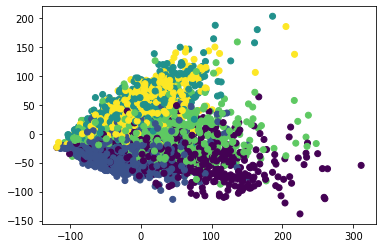

In [3]:
f_pca = PCA(n_components=2).fit_transform(f_all)
print(f_pca.shape)
plt.scatter(*f_pca.T, c=y_all)
#plt.savefig("/content/drive/My Drive/pca.png")

#Q23 : t-SNE


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


(3670, 2)


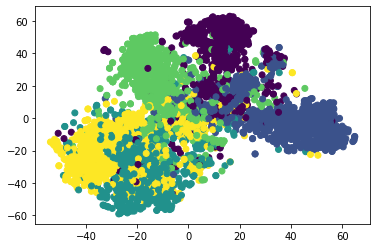

In [ ]:
#Q23
f_tsne = sklearn.manifold.TSNE(n_components = 2).fit_transform(f_all)
print(f_tsne.shape)
plt.scatter(*f_tsne.T, c=y_all)
#plt.savefig("/content/drive/My Drive/tsne.png")

#SVD

In [ ]:
### SVD
def funcsvd(inputs):
  f_svd = TruncatedSVD(n_components=50).fit_transform(inputs)
  return f_svd
#print(f_svd.shape)
#plt.scatter(*f_svd.T, c=y_all)

#UMAP

In [ ]:

##UMAP
def funcumap(inputs):
  f_umap = umap.UMAP(n_neighbors=50, metric = 'cosine').fit_transform(inputs)
  return f_umap
#print(f_svd.shape)

#Clustering algorithms

In [ ]:
def kmeans1(inputs):
  kmeans = KMeans(n_clusters=5, random_state=0)
  #return kmeans
  yp = kmeans.fit_predict(inputs)
  return yp
  #print(y_all.shape, yp.shape)
  #rand_score(y_all,yp)
#print(kmeans.shape)
#plt.scatter(*kmeans, c=y_all)

In [ ]:
def ac1(inputs):
  clustering = AgglomerativeClustering(n_clusters=5)
 # return clustering
  y_ac=clustering.fit_predict(inputs)
  return y_ac
#rand_score(y_all,y_ac)

In [ ]:
#data, _ = make_blobs(1000)
def hdbscan1(inputs):
  clusterer = hdbscan.HDBSCAN(min_cluster_size=5, min_samples=1)
  #return clusterer
  cluster_labels = clusterer.fit_predict(inputs)
  return cluster_labels

def hdbscan2(inputs):
  clusterer = hdbscan.HDBSCAN(min_cluster_size=100, min_samples=30)
  #return clusterer
  cluster_labels = clusterer.fit_predict(inputs)
  return cluster_labels

def hdbscan3(inputs):
  clusterer = hdbscan.HDBSCAN(min_cluster_size=100, min_samples=5)
  #return clusterer
  cluster_labels = clusterer.fit_predict(inputs)
  return cluster_labels

def hdbscan4(inputs):
  clusterer = hdbscan.HDBSCAN(min_cluster_size=200, min_samples=30)
  #return clusterer
  cluster_labels = clusterer.fit_predict(inputs)
  return cluster_labels

def hdbscan5(inputs):
  clusterer = hdbscan.HDBSCAN(min_cluster_size=10, min_samples=1)
  #return clusterer
  cluster_labels = clusterer.fit_predict(inputs)
  return cluster_labels

#rand_score(y_all,cluster_labels)

In [ ]:
def doNothing(inputs):
  return inputs

#Autoencoder

In [ ]:
class Autoencoder(torch.nn.Module, TransformerMixin):
    def __init__(self, n_components=2):
        super().__init__()
        self.n_components = n_components
        self.n_features = None  # to be determined with data
        self.encoder = None
        self.decoder = None
        
    def _create_encoder(self):
        return nn.Sequential(
            nn.Linear(4096, 1280),
            nn.ReLU(True),
            nn.Linear(1280, 640),
            nn.ReLU(True), nn.Linear(640, 120), nn.ReLU(True), nn.Linear(120, self.n_components))
    
    def _create_decoder(self):
        return nn.Sequential(
            nn.Linear(self.n_components, 120),
            nn.ReLU(True),
            nn.Linear(120, 640),
            nn.ReLU(True),
            nn.Linear(640, 1280),
            nn.ReLU(True), nn.Linear(1280, 4096))
    
    def forward(self, X):
        encoded = self.encoder(X)
        decoded = self.decoder(encoded)
        return decoded
    
    def fit(self, X):
        X = torch.tensor(X, dtype=torch.float32, device='cuda')
        self.n_features = X.shape[1]
        self.encoder = self._create_encoder()
        self.decoder = self._create_decoder()
        self.cuda()
        self.train()
        
        criterion = nn.MSELoss()
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3, weight_decay=1e-5)

        dataset = TensorDataset(X)
        dataloader = DataLoader(dataset, batch_size=128, shuffle=True)

        for epoch in tqdm(range(100)):
            for (X_,) in dataloader:
                X_ = X_.cuda()
                # ===================forward=====================
                output = self(X_)
                loss = criterion(output, X_)
                # ===================backward====================
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

        return self     
        
    def transform(self, X):
        X = torch.tensor(X, dtype=torch.float32, device='cuda')
        self.eval()
        with torch.no_grad():
            return self.encoder(X).cpu().numpy()

In [ ]:
X_em =Autoencoder(50).fit_transform(f_all)
print(X_em.shape)

100%|██████████| 100/100 [00:22<00:00,  4.41it/s]

(3670, 50)


In [ ]:
def autoencode1(inputs):
  X_em =Autoencoder(50).fit_transform(inputs)
  print(X_em.shape)
  return X_em
  

#Q24: Grid Search

In [ ]:
## grid search

dim_red = [doNothing, funcsvd, funcumap, autoencode1]
clustering = [kmeans1, ac1, hdbscan1,  hdbscan2,  hdbscan3, hdbscan4, hdbscan5]
for cluster in clustering:
  for method in dim_red:
    f_reduced = method(f_all)
    print( f_reduced.shape)
    outputs = cluster(f_reduced)
    print(outputs.shape, f_reduced.shape, y_all.shape)
  
    score = adjusted_rand_score(y_all,outputs)
    print(cluster, method,score)


(3670, 4096)
(3670,) (3670, 4096) (3670,)
<function kmeans1 at 0x7f7a1066c290> <function doNothing at 0x7f7a1066c560> 0.19586505816124616
(3670, 50)
(3670,) (3670, 50) (3670,)
<function kmeans1 at 0x7f7a1066c290> <function funcsvd at 0x7f7a106425f0> 0.19332022535307106


/usr/local/lib/python3.7/dist-packages/numba/np/ufunc/parallel.py:363: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.
  warnings.warn(problem)


(3670, 2)
(3670,) (3670, 2) (3670,)
<function kmeans1 at 0x7f7a1066c290> <function funcumap at 0x7f7a10642ef0> 0.44085747327184416


100%|██████████| 100/100 [00:22<00:00,  4.50it/s]


(3670, 50)
(3670, 50)
(3670,) (3670, 50) (3670,)
<function kmeans1 at 0x7f7a1066c290> <function autoencode1 at 0x7f7a10642f80> 0.1910599838932507
(3670, 4096)
(3670,) (3670, 4096) (3670,)
<function ac1 at 0x7f7a1066c320> <function doNothing at 0x7f7a1066c560> 0.18855278251971858
(3670, 50)
(3670,) (3670, 50) (3670,)
<function ac1 at 0x7f7a1066c320> <function funcsvd at 0x7f7a106425f0> 0.13628642904719862
(3670, 2)
(3670,) (3670, 2) (3670,)
<function ac1 at 0x7f7a1066c320> <function funcumap at 0x7f7a10642ef0> 0.4359271414621078


100%|██████████| 100/100 [00:22<00:00,  4.50it/s]


(3670, 50)
(3670, 50)
(3670,) (3670, 50) (3670,)
<function ac1 at 0x7f7a1066c320> <function autoencode1 at 0x7f7a10642f80> 0.20592588909317708
(3670, 4096)
(3670,) (3670, 4096) (3670,)
<function hdbscan1 at 0x7f7a1066ccb0> <function doNothing at 0x7f7a1066c560> 0.014983034591038287
(3670, 50)
(3670,) (3670, 50) (3670,)
<function hdbscan1 at 0x7f7a1066ccb0> <function funcsvd at 0x7f7a106425f0> 0.024254361194687615
(3670, 2)
(3670,) (3670, 2) (3670,)
<function hdbscan1 at 0x7f7a1066ccb0> <function funcumap at 0x7f7a10642ef0> 0.19748396770271676


100%|██████████| 100/100 [00:22<00:00,  4.49it/s]


(3670, 50)
(3670, 50)
(3670,) (3670, 50) (3670,)
<function hdbscan1 at 0x7f7a1066ccb0> <function autoencode1 at 0x7f7a10642f80> 0.025211996107668992
(3670, 4096)
(3670,) (3670, 4096) (3670,)
<function hdbscan2 at 0x7f7a1066c170> <function doNothing at 0x7f7a1066c560> 0.0
(3670, 50)
(3670,) (3670, 50) (3670,)
<function hdbscan2 at 0x7f7a1066c170> <function funcsvd at 0x7f7a106425f0> 0.0
(3670, 2)
(3670,) (3670, 2) (3670,)
<function hdbscan2 at 0x7f7a1066c170> <function funcumap at 0x7f7a10642ef0> 0.09665559417492456


100%|██████████| 100/100 [00:22<00:00,  4.50it/s]


(3670, 50)
(3670, 50)
(3670,) (3670, 50) (3670,)
<function hdbscan2 at 0x7f7a1066c170> <function autoencode1 at 0x7f7a10642f80> 0.0
(3670, 4096)
(3670,) (3670, 4096) (3670,)
<function hdbscan3 at 0x7f7a1066c200> <function doNothing at 0x7f7a1066c560> 0.0
(3670, 50)
(3670,) (3670, 50) (3670,)
<function hdbscan3 at 0x7f7a1066c200> <function funcsvd at 0x7f7a106425f0> 0.0
(3670, 2)
(3670,) (3670, 2) (3670,)
<function hdbscan3 at 0x7f7a1066c200> <function funcumap at 0x7f7a10642ef0> 0.09607707705936752


100%|██████████| 100/100 [00:22<00:00,  4.50it/s]


(3670, 50)
(3670, 50)
(3670,) (3670, 50) (3670,)
<function hdbscan3 at 0x7f7a1066c200> <function autoencode1 at 0x7f7a10642f80> 0.0
(3670, 4096)
(3670,) (3670, 4096) (3670,)
<function hdbscan4 at 0x7f7a10713dd0> <function doNothing at 0x7f7a1066c560> 0.0
(3670, 50)
(3670,) (3670, 50) (3670,)
<function hdbscan4 at 0x7f7a10713dd0> <function funcsvd at 0x7f7a106425f0> 0.0
(3670, 2)
(3670,) (3670, 2) (3670,)
<function hdbscan4 at 0x7f7a10713dd0> <function funcumap at 0x7f7a10642ef0> 0.09691737954933624


100%|██████████| 100/100 [00:22<00:00,  4.50it/s]


(3670, 50)
(3670, 50)
(3670,) (3670, 50) (3670,)
<function hdbscan4 at 0x7f7a10713dd0> <function autoencode1 at 0x7f7a10642f80> 0.0
(3670, 4096)
(3670,) (3670, 4096) (3670,)
<function hdbscan5 at 0x7f7a10642b00> <function doNothing at 0x7f7a1066c560> 0.015014212771105666
(3670, 50)
(3670,) (3670, 50) (3670,)
<function hdbscan5 at 0x7f7a10642b00> <function funcsvd at 0x7f7a106425f0> 0.01641908904146645
(3670, 2)
(3670,) (3670, 2) (3670,)
<function hdbscan5 at 0x7f7a10642b00> <function funcumap at 0x7f7a10642ef0> 0.20985292346172957


100%|██████████| 100/100 [00:22<00:00,  4.50it/s]


(3670, 50)
(3670, 50)
(3670,) (3670, 50) (3670,)
<function hdbscan5 at 0x7f7a10642b00> <function autoencode1 at 0x7f7a10642f80> 0.021902594900760027


# Q25: MLP Classifier

In [4]:
class MLP(torch.nn.Module):
    def __init__(self, num_features):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(num_features, 1280),
            nn.ReLU(True),
            nn.Linear(1280, 640),
            nn.ReLU(True), 
            nn.Linear(640, 5),
            nn.LogSoftmax(dim=1)
        )
        self.cuda()
    
    
    def forward(self, X):
        return self.model(X)
    
    def train(self, X, y):
        X = torch.tensor(X, dtype=torch.float32, device='cuda')
        y = torch.tensor(y, dtype=torch.int64, device='cuda')

        self.model.train()
        
        criterion = nn.NLLLoss()
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3, weight_decay=1e-5)

        dataset = TensorDataset(X, y)
        dataloader = DataLoader(dataset, batch_size=128, shuffle=True)
        
        for epoch in tqdm(range(100)):
            print('Epoch {}/{}'.format(epoch, 100 - 1))
            print('-' * 10)
            
            for (X_, y_) in dataloader:
              #Zero the parameter gradient
              outputs = self.model(X_)
              loss = criterion(outputs,y_ )
              optimizer.zero_grad()
              loss.backward()
              optimizer.step()       
            print('{} Loss: ', loss)
        return self
    
    def eval(self, X_test, y_test):
        ##################################
        # you should implement this part #
        ##################################
        X_test = torch.tensor(X_test, dtype=torch.float32, device='cuda')
        y_test = torch.tensor(y_test, dtype=torch.int64, device='cuda')
        criterion = nn.NLLLoss()
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3, weight_decay=1e-5)

        dataset = TensorDataset(X_test, y_test)
        dataloader = DataLoader(dataset, batch_size=128, shuffle=True)
       # total_loss=[]
        #outputs_all=[]
        tot=0
        corr=0
        with torch.no_grad():
          for (X_test, y_test) in dataloader:
            outputs = self.model(X_test)
            
            _,pred= torch.max(outputs,1)
            tot+= y_test.size(0)
            corr += (pred==y_test).sum().item()
        accuracy = (corr/tot)*100
      

        #np.savez(filename, f_all=f_all, y_all=y_all)
      #  print(f'\n------------------------\nTotal loss: {total_loss}\n-----------------------------')
        print(f'\n------------------------\nAccuracy: {accuracy}\n-----------------------------')
       # raise NotImplementedError


# No Dim Reduction: Train-Test

In [ ]:

X_train, X_test,y_train,  y_test = train_test_split(f_all,y_all, test_size=0.2, random_state=0)
print(X_test)
print(len(X_train), len(X_train[0]), len(X_test), len(X_test[0]))
a = MLP(len(X_train[0]))
a.train(X_train, y_train)
a.eval(X_test, y_test)


[[-1.09391952 -0.74333471  2.34696531 ... -6.02570391 -1.64820957
  -0.17426714]
 [-0.49618384 -0.33805868 -2.40786266 ... -3.74040341  0.2785576
   3.51135683]
 [-3.4009316  -1.61380982 -0.79997665 ... -7.20987749  0.27326632
  -0.61771256]
 ...
 [-2.11876965  0.63564527  0.75016475 ... -6.43461275 -0.29414183
   1.1748122 ]
 [-2.34383416 -0.68400943 -2.0577414  ... -1.26587486  2.34199524
   3.21130347]
 [-0.99264961 -0.93188149  0.21016225 ... -0.64660215  1.13032568
   2.32165885]]
2936 4096 734 4096


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 0/99
----------
{} Loss:  

  1%|          | 1/100 [00:00<00:18,  5.23it/s]

tensor(0.4630, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch 1/99
----------


  2%|▏         | 2/100 [00:00<00:18,  5.42it/s]

{} Loss:  tensor(0.4251, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch 2/99
----------
{} Loss:  

  3%|▎         | 3/100 [00:00<00:17,  5.47it/s]

tensor(0.2124, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch 3/99
----------
{} Loss:  

  4%|▍         | 4/100 [00:00<00:17,  5.51it/s]

tensor(0.1707, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch 4/99
----------


  5%|▌         | 5/100 [00:00<00:17,  5.53it/s]

{} Loss:  tensor(0.0871, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch 5/99
----------
{} Loss:  

  6%|▌         | 6/100 [00:01<00:16,  5.53it/s]

tensor(0.0404, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch 6/99
----------
{} Loss:  

  7%|▋         | 7/100 [00:01<00:16,  5.54it/s]

tensor(0.0428, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch 7/99
----------


  8%|▊         | 8/100 [00:01<00:16,  5.54it/s]

{} Loss:  tensor(0.0221, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch 8/99
----------
{} Loss:  

  9%|▉         | 9/100 [00:01<00:16,  5.52it/s]

tensor(0.0500, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch 9/99
----------
{} Loss:  

 10%|█         | 10/100 [00:01<00:16,  5.52it/s]

tensor(0.0161, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch 10/99
----------


 11%|█         | 11/100 [00:01<00:16,  5.54it/s]

{} Loss:  tensor(0.0350, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch 11/99
----------
{} Loss:  

 12%|█▏        | 12/100 [00:02<00:15,  5.55it/s]

tensor(0.0283, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch 12/99
----------
{} Loss:  

 13%|█▎        | 13/100 [00:02<00:15,  5.54it/s]

tensor(0.0137, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch 13/99
----------


 14%|█▍        | 14/100 [00:02<00:15,  5.55it/s]

{} Loss:  tensor(0.0053, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch 14/99
----------
{} Loss:  

 15%|█▌        | 15/100 [00:02<00:15,  5.55it/s]

tensor(0.0202, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch 15/99
----------
{} Loss:  

 16%|█▌        | 16/100 [00:02<00:15,  5.53it/s]

tensor(0.0290, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch 16/99
----------


 17%|█▋        | 17/100 [00:03<00:14,  5.56it/s]

{} Loss:  tensor(0.0471, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch 17/99
----------
{} Loss:  

 18%|█▊        | 18/100 [00:03<00:14,  5.56it/s]

tensor(0.0711, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch 18/99
----------
{} Loss:  

 19%|█▉        | 19/100 [00:03<00:14,  5.58it/s]

tensor(0.0124, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch 19/99
----------


 20%|██        | 20/100 [00:03<00:14,  5.57it/s]

{} Loss:  tensor(0.0181, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch 20/99
----------
{} Loss:  

 21%|██        | 21/100 [00:03<00:14,  5.55it/s]

tensor(0.1684, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch 21/99
----------
{} Loss:  

 22%|██▏       | 22/100 [00:03<00:14,  5.55it/s]

tensor(0.0369, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch 22/99
----------


 23%|██▎       | 23/100 [00:04<00:13,  5.58it/s]

{} Loss:  tensor(0.0264, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch 23/99
----------
{} Loss:  

 24%|██▍       | 24/100 [00:04<00:13,  5.56it/s]

tensor(0.0372, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch 24/99
----------
{} Loss:  

 25%|██▌       | 25/100 [00:04<00:13,  5.54it/s]

tensor(0.0395, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch 25/99
----------


 26%|██▌       | 26/100 [00:04<00:13,  5.54it/s]

{} Loss:  tensor(0.0046, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch 26/99
----------
{} Loss:  

 27%|██▋       | 27/100 [00:04<00:13,  5.53it/s]

tensor(0.0002, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch 27/99
----------
{} Loss:  

 28%|██▊       | 28/100 [00:05<00:12,  5.55it/s]

tensor(0.0003, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch 28/99
----------


 29%|██▉       | 29/100 [00:05<00:12,  5.56it/s]

{} Loss:  tensor(0.0002, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch 29/99
----------
{} Loss:  

 30%|███       | 30/100 [00:05<00:12,  5.55it/s]

tensor(0.0001, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch 30/99
----------
{} Loss:  

 31%|███       | 31/100 [00:05<00:12,  5.56it/s]

tensor(0.0097, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch 31/99
----------


 32%|███▏      | 32/100 [00:05<00:12,  5.57it/s]

{} Loss:  tensor(0.0002, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch 32/99
----------
{} Loss:  

 33%|███▎      | 33/100 [00:05<00:12,  5.57it/s]

tensor(9.3862e-05, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch 33/99
----------
{} Loss:  

 34%|███▍      | 34/100 [00:06<00:11,  5.56it/s]

tensor(0.0004, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch 34/99
----------


 35%|███▌      | 35/100 [00:06<00:11,  5.55it/s]

{} Loss:  tensor(6.4923e-05, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch 35/99
----------
{} Loss:  

 36%|███▌      | 36/100 [00:06<00:11,  5.55it/s]

tensor(8.6929e-05, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch 36/99
----------
{} Loss:  

 37%|███▋      | 37/100 [00:06<00:11,  5.53it/s]

tensor(0.0001, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch 37/99
----------


 38%|███▊      | 38/100 [00:06<00:11,  5.56it/s]

{} Loss:  tensor(4.6771e-05, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch 38/99
----------
{} Loss:  

 39%|███▉      | 39/100 [00:07<00:10,  5.56it/s]

tensor(4.7742e-05, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch 39/99
----------
{} Loss:  

 40%|████      | 40/100 [00:07<00:10,  5.58it/s]

tensor(6.1079e-05, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch 40/99
----------


 41%|████      | 41/100 [00:07<00:10,  5.60it/s]

{} Loss:  tensor(3.7284e-05, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch 41/99
----------
{} Loss:  

 42%|████▏     | 42/100 [00:07<00:10,  5.59it/s]

tensor(4.8155e-05, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch 42/99
----------
{} Loss:  

 43%|████▎     | 43/100 [00:07<00:10,  5.57it/s]

tensor(7.1954e-05, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch 43/99
----------


 44%|████▍     | 44/100 [00:07<00:10,  5.55it/s]

{} Loss:  tensor(7.8264e-05, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch 44/99
----------
{} Loss:  

 45%|████▌     | 45/100 [00:08<00:09,  5.54it/s]

tensor(6.0224e-05, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch 45/99
----------
{} Loss:  

 46%|████▌     | 46/100 [00:08<00:09,  5.54it/s]

tensor(0.0001, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch 46/99
----------


 47%|████▋     | 47/100 [00:08<00:09,  5.53it/s]

{} Loss:  tensor(0.0121, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch 47/99
----------
{} Loss:  

 48%|████▊     | 48/100 [00:08<00:09,  5.54it/s]

tensor(7.7042e-05, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch 48/99
----------
{} Loss:  

 49%|████▉     | 49/100 [00:08<00:09,  5.54it/s]

tensor(8.9791e-05, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch 49/99
----------


 50%|█████     | 50/100 [00:09<00:09,  5.54it/s]

{} Loss:  tensor(4.7847e-05, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch 50/99
----------
{} Loss:  

 51%|█████     | 51/100 [00:09<00:08,  5.54it/s]

tensor(6.9574e-05, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch 51/99
----------
{} Loss:  

 52%|█████▏    | 52/100 [00:09<00:08,  5.55it/s]

tensor(3.9530e-05, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch 52/99
----------


 53%|█████▎    | 53/100 [00:09<00:08,  5.55it/s]

{} Loss:  tensor(4.8240e-05, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch 53/99
----------
{} Loss:  

 54%|█████▍    | 54/100 [00:09<00:08,  5.53it/s]

tensor(0.0072, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch 54/99
----------
{} Loss:  

 55%|█████▌    | 55/100 [00:09<00:08,  5.53it/s]

tensor(3.6068e-05, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch 55/99
----------


 56%|█████▌    | 56/100 [00:10<00:07,  5.51it/s]

{} Loss:  tensor(5.6758e-05, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch 56/99
----------
{} Loss:  

 57%|█████▋    | 57/100 [00:10<00:07,  5.50it/s]

tensor(0.0070, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch 57/99
----------
{} Loss:  

 58%|█████▊    | 58/100 [00:10<00:07,  5.51it/s]

tensor(0.0058, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch 58/99
----------


 59%|█████▉    | 59/100 [00:10<00:07,  5.51it/s]

{} Loss:  tensor(3.8720e-05, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch 59/99
----------
{} Loss:  

 60%|██████    | 60/100 [00:10<00:07,  5.51it/s]

tensor(3.1660e-05, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch 60/99
----------
{} Loss:  

 61%|██████    | 61/100 [00:11<00:07,  5.51it/s]

tensor(4.4017e-05, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch 61/99
----------


 62%|██████▏   | 62/100 [00:11<00:06,  5.52it/s]

{} Loss:  tensor(2.8616e-05, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch 62/99
----------
{} Loss:  

 63%|██████▎   | 63/100 [00:11<00:06,  5.52it/s]

tensor(0.0075, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch 63/99
----------
{} Loss:  

 64%|██████▍   | 64/100 [00:11<00:06,  5.52it/s]

tensor(1.8718e-05, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch 64/99
----------


 65%|██████▌   | 65/100 [00:11<00:06,  5.53it/s]

{} Loss:  tensor(4.0219e-05, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch 65/99
----------
{} Loss:  

 66%|██████▌   | 66/100 [00:11<00:06,  5.52it/s]

tensor(3.5647e-05, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch 66/99
----------
{} Loss:  

 67%|██████▋   | 67/100 [00:12<00:05,  5.51it/s]

tensor(0.0068, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch 67/99
----------


 68%|██████▊   | 68/100 [00:12<00:05,  5.52it/s]

{} Loss:  tensor(1.7636e-05, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch 68/99
----------
{} Loss:  

 69%|██████▉   | 69/100 [00:12<00:05,  5.53it/s]

tensor(1.0388e-05, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch 69/99
----------
{} Loss:  

 70%|███████   | 70/100 [00:12<00:05,  5.54it/s]

tensor(5.2463e-05, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch 70/99
----------


 71%|███████   | 71/100 [00:12<00:05,  5.54it/s]

{} Loss:  tensor(0.0002, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch 71/99
----------
{} Loss:  

 72%|███████▏  | 72/100 [00:12<00:05,  5.53it/s]

tensor(3.8456e-05, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch 72/99
----------
{} Loss:  

 73%|███████▎  | 73/100 [00:13<00:04,  5.53it/s]

tensor(6.2066e-05, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch 73/99
----------


 74%|███████▍  | 74/100 [00:13<00:04,  5.56it/s]

{} Loss:  tensor(6.0009e-05, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch 74/99
----------
{} Loss:  

 75%|███████▌  | 75/100 [00:13<00:04,  5.56it/s]

tensor(1.9538e-05, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch 75/99
----------
{} Loss:  

 76%|███████▌  | 76/100 [00:13<00:04,  5.58it/s]

tensor(2.9593e-05, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch 76/99
----------


 77%|███████▋  | 77/100 [00:13<00:04,  5.57it/s]

{} Loss:  tensor(1.1768e-05, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch 77/99
----------
{} Loss:  

 78%|███████▊  | 78/100 [00:14<00:03,  5.56it/s]

tensor(2.7319e-05, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch 78/99
----------
{} Loss:  

 79%|███████▉  | 79/100 [00:14<00:03,  5.51it/s]

tensor(0.0071, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch 79/99
----------


 80%|████████  | 80/100 [00:14<00:03,  5.50it/s]

{} Loss:  tensor(1.7192e-05, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch 80/99
----------
{} Loss:  

 81%|████████  | 81/100 [00:14<00:03,  5.51it/s]

tensor(3.5620e-05, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch 81/99
----------
{} Loss:  

 82%|████████▏ | 82/100 [00:14<00:03,  5.53it/s]

tensor(1.4779e-05, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch 82/99
----------


 83%|████████▎ | 83/100 [00:14<00:03,  5.53it/s]

{} Loss:  tensor(1.6122e-05, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch 83/99
----------
{} Loss:  

 84%|████████▍ | 84/100 [00:15<00:02,  5.53it/s]

tensor(1.1470e-05, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch 84/99
----------
{} Loss:  

 85%|████████▌ | 85/100 [00:15<00:02,  5.53it/s]

tensor(2.3884e-05, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch 85/99
----------


 86%|████████▌ | 86/100 [00:15<00:02,  5.53it/s]

{} Loss:  tensor(1.3206e-05, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch 86/99
----------
{} Loss:  

 87%|████████▋ | 87/100 [00:15<00:02,  5.55it/s]

tensor(1.6761e-05, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch 87/99
----------
{} Loss:  

 88%|████████▊ | 88/100 [00:15<00:02,  5.56it/s]

tensor(1.0820e-05, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch 88/99
----------


 89%|████████▉ | 89/100 [00:16<00:01,  5.55it/s]

{} Loss:  tensor(0.0073, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch 89/99
----------
{} Loss:  

 90%|█████████ | 90/100 [00:16<00:01,  5.55it/s]

tensor(1.3047e-05, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch 90/99
----------
{} Loss:  

 91%|█████████ | 91/100 [00:16<00:01,  5.52it/s]

tensor(1.8691e-05, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch 91/99
----------


 92%|█████████▏| 92/100 [00:16<00:01,  5.52it/s]

{} Loss:  tensor(6.7678e-06, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch 92/99
----------
{} Loss:  

 93%|█████████▎| 93/100 [00:16<00:01,  5.53it/s]

tensor(0.0108, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch 93/99
----------
{} Loss:  

 94%|█████████▍| 94/100 [00:16<00:01,  5.53it/s]

tensor(1.3870e-05, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch 94/99
----------


 95%|█████████▌| 95/100 [00:17<00:00,  5.52it/s]

{} Loss:  tensor(1.1540e-05, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch 95/99
----------
{} Loss:  

 96%|█████████▌| 96/100 [00:17<00:00,  5.54it/s]

tensor(1.3126e-05, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch 96/99
----------
{} Loss:  

 97%|█████████▋| 97/100 [00:17<00:00,  5.54it/s]

tensor(1.9414e-05, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch 97/99
----------


 98%|█████████▊| 98/100 [00:17<00:00,  5.55it/s]

{} Loss:  tensor(0.0080, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch 98/99
----------
{} Loss:  

 99%|█████████▉| 99/100 [00:17<00:00,  5.54it/s]

tensor(1.0279e-05, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch 99/99
----------
{} Loss:  

100%|██████████| 100/100 [00:18<00:00,  5.54it/s]

tensor(8.7753e-06, device='cuda:0', grad_fn=<NllLossBackward0>)



------------------------
Accuracy: 90.87193460490464
-----------------------------


In [ ]:
a.eval(X_test, y_test)


------------------------
Accuracy: 90.87193460490464
-----------------------------


# UMAP : Train-Test

In [ ]:
#funcsvd, funcumap, autoencode1
f_reduced = funcumap(f_all)

In [ ]:
X_train, X_test,y_train,  y_test = train_test_split(f_reduced,y_all, test_size=0.2, random_state=0)
print(X_test)
print(len(X_train), len(X_train[0]), len(X_test), len(X_test[0]))
c = MLP(len(X_train[0]))
c.train(X_train, y_train)

[[-3.7132633   1.2334253 ]
 [ 1.3059366  -0.5873665 ]
 [ 0.2195643  -0.25338644]
 ...
 [ 6.023107   -0.08438105]
 [ 2.0885084  -3.3042884 ]
 [ 5.1254644   1.5365621 ]]
2936 2 734 2


  1%|          | 1/100 [00:00<00:14,  6.85it/s]

Epoch 0/99
----------
{} Loss:  tensor(0.5292, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch 1/99
----------


  3%|▎         | 3/100 [00:00<00:13,  6.93it/s]

{} Loss:  tensor(0.4173, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch 2/99
----------
{} Loss:  tensor(0.5776, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch 3/99
----------


  5%|▌         | 5/100 [00:00<00:13,  6.84it/s]

{} Loss:  tensor(0.5357, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch 4/99
----------
{} Loss:  tensor(0.4369, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch 5/99
----------


  7%|▋         | 7/100 [00:01<00:13,  6.78it/s]

{} Loss:  tensor(0.3847, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch 6/99
----------
{} Loss:  tensor(0.6480, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch 7/99
----------


  9%|▉         | 9/100 [00:01<00:13,  6.87it/s]

{} Loss:  tensor(0.4869, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch 8/99
----------
{} Loss:  tensor(0.5619, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch 9/99
----------


 11%|█         | 11/100 [00:01<00:12,  6.88it/s]

{} Loss:  tensor(0.4572, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch 10/99
----------
{} Loss:  tensor(0.4980, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch 11/99
----------


 13%|█▎        | 13/100 [00:01<00:12,  7.08it/s]

{} Loss:  tensor(0.3319, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch 12/99
----------
{} Loss:  tensor(0.6985, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch 13/99
----------


 15%|█▌        | 15/100 [00:02<00:11,  7.24it/s]

{} Loss:  tensor(0.6038, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch 14/99
----------
{} Loss:  tensor(0.3420, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch 15/99
----------


 17%|█▋        | 17/100 [00:02<00:11,  7.23it/s]

{} Loss:  tensor(0.5037, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch 16/99
----------
{} Loss:  tensor(0.4698, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch 17/99
----------


 19%|█▉        | 19/100 [00:02<00:11,  7.10it/s]

{} Loss:  tensor(0.5607, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch 18/99
----------
{} Loss:  tensor(0.3632, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch 19/99
----------


 21%|██        | 21/100 [00:03<00:11,  6.87it/s]

{} Loss:  tensor(0.4411, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch 20/99
----------
{} Loss:  tensor(0.4684, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch 21/99
----------


 23%|██▎       | 23/100 [00:03<00:11,  6.92it/s]

{} Loss:  tensor(0.5389, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch 22/99
----------
{} Loss:  tensor(0.5098, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch 23/99
----------


 25%|██▌       | 25/100 [00:03<00:11,  6.61it/s]

{} Loss:  tensor(0.4894, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch 24/99
----------
{} Loss:  tensor(0.5222, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch 25/99
----------


 27%|██▋       | 27/100 [00:03<00:10,  6.84it/s]

{} Loss:  tensor(0.4627, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch 26/99
----------
{} Loss:  tensor(0.5353, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch 27/99
----------


 29%|██▉       | 29/100 [00:04<00:10,  6.89it/s]

{} Loss:  tensor(0.5039, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch 28/99
----------
{} Loss:  tensor(0.3970, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch 29/99
----------


 31%|███       | 31/100 [00:04<00:09,  7.08it/s]

{} Loss:  tensor(0.4700, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch 30/99
----------
{} Loss:  tensor(0.3664, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch 31/99
----------


 33%|███▎      | 33/100 [00:04<00:09,  7.06it/s]

{} Loss:  tensor(0.5831, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch 32/99
----------
{} Loss:  tensor(0.3712, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch 33/99
----------


 35%|███▌      | 35/100 [00:05<00:09,  6.94it/s]

{} Loss:  tensor(0.5151, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch 34/99
----------
{} Loss:  tensor(0.5843, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch 35/99
----------


 37%|███▋      | 37/100 [00:05<00:09,  6.98it/s]

{} Loss:  tensor(0.2643, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch 36/99
----------
{} Loss:  tensor(0.4322, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch 37/99
----------


 39%|███▉      | 39/100 [00:05<00:08,  6.79it/s]

{} Loss:  tensor(0.5621, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch 38/99
----------
{} Loss:  tensor(0.4219, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch 39/99
----------


 41%|████      | 41/100 [00:05<00:08,  6.88it/s]

{} Loss:  tensor(0.4766, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch 40/99
----------
{} Loss:  tensor(0.5194, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch 41/99
----------


 43%|████▎     | 43/100 [00:06<00:08,  6.99it/s]

{} Loss:  tensor(0.4489, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch 42/99
----------
{} Loss:  tensor(0.3917, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch 43/99
----------


 45%|████▌     | 45/100 [00:06<00:08,  6.84it/s]

{} Loss:  tensor(0.5393, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch 44/99
----------
{} Loss:  tensor(0.4257, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch 45/99
----------


 47%|████▋     | 47/100 [00:06<00:07,  6.87it/s]

{} Loss:  tensor(0.5135, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch 46/99
----------
{} Loss:  tensor(0.4368, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch 47/99
----------


 49%|████▉     | 49/100 [00:07<00:07,  6.95it/s]

{} Loss:  tensor(0.4796, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch 48/99
----------
{} Loss:  tensor(0.4688, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch 49/99
----------


 51%|█████     | 51/100 [00:07<00:07,  6.88it/s]

{} Loss:  tensor(0.5442, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch 50/99
----------
{} Loss:  tensor(0.4314, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch 51/99
----------


 53%|█████▎    | 53/100 [00:07<00:07,  6.69it/s]

{} Loss:  tensor(0.4377, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch 52/99
----------
{} Loss:  tensor(0.4711, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch 53/99
----------


 55%|█████▌    | 55/100 [00:07<00:06,  6.84it/s]

{} Loss:  tensor(0.4059, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch 54/99
----------
{} Loss:  tensor(0.4961, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch 55/99
----------


 57%|█████▋    | 57/100 [00:08<00:06,  6.90it/s]

{} Loss:  tensor(0.4644, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch 56/99
----------
{} Loss:  tensor(0.3697, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch 57/99
----------


 59%|█████▉    | 59/100 [00:08<00:05,  6.90it/s]

{} Loss:  tensor(0.4605, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch 58/99
----------
{} Loss:  tensor(0.5721, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch 59/99
----------


 61%|██████    | 61/100 [00:08<00:05,  6.60it/s]

{} Loss:  tensor(0.4499, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch 60/99
----------
{} Loss:  tensor(0.4426, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch 61/99
----------


 63%|██████▎   | 63/100 [00:09<00:05,  6.61it/s]

{} Loss:  tensor(0.4003, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch 62/99
----------
{} Loss:  tensor(0.4668, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch 63/99
----------


 64%|██████▍   | 64/100 [00:09<00:06,  5.57it/s]

{} Loss:  tensor(0.4958, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch 64/99
----------


 66%|██████▌   | 66/100 [00:09<00:06,  4.90it/s]

{} Loss:  tensor(0.4654, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch 65/99
----------
{} Loss:  tensor(0.5492, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch 66/99
----------


 68%|██████▊   | 68/100 [00:10<00:06,  4.60it/s]

{} Loss:  tensor(0.3516, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch 67/99
----------
{} Loss:  tensor(0.5297, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch 68/99
----------


 69%|██████▉   | 69/100 [00:10<00:06,  4.61it/s]

{} Loss:  tensor(0.5117, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch 69/99
----------


 71%|███████   | 71/100 [00:10<00:05,  5.12it/s]

{} Loss:  tensor(0.6094, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch 70/99
----------
{} Loss:  tensor(0.6313, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch 71/99
----------


 72%|███████▏  | 72/100 [00:11<00:05,  5.24it/s]

{} Loss:  tensor(0.4941, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch 72/99
----------


 74%|███████▍  | 74/100 [00:11<00:04,  5.38it/s]

{} Loss:  tensor(0.4282, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch 73/99
----------
{} Loss:  tensor(0.3620, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch 74/99
----------


 76%|███████▌  | 76/100 [00:11<00:04,  5.15it/s]

{} Loss:  tensor(0.4523, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch 75/99
----------
{} Loss:  tensor(0.5105, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch 76/99
----------


 78%|███████▊  | 78/100 [00:12<00:04,  5.28it/s]

{} Loss:  tensor(0.4465, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch 77/99
----------
{} Loss:  tensor(0.5527, device='cuda:0', grad_fn=<NllLossBackward0>)


 80%|████████  | 80/100 [00:12<00:03,  5.68it/s]

Epoch 78/99
----------
{} Loss:  tensor(0.3939, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch 79/99
----------
{} Loss:  tensor(0.3895, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch 80/99
----------


 82%|████████▏ | 82/100 [00:12<00:03,  5.80it/s]

{} Loss:  tensor(0.6147, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch 81/99
----------
{} Loss:  tensor(0.5321, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch 82/99
----------


 84%|████████▍ | 84/100 [00:13<00:02,  5.40it/s]

{} Loss:  tensor(0.3821, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch 83/99
----------
{} Loss:  tensor(0.3567, device='cuda:0', grad_fn=<NllLossBackward0>)


 85%|████████▌ | 85/100 [00:13<00:02,  5.47it/s]

Epoch 84/99
----------
{} Loss:  tensor(0.4226, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch 85/99
----------


 87%|████████▋ | 87/100 [00:13<00:02,  5.95it/s]

{} Loss:  tensor(0.2758, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch 86/99
----------
{} Loss:  tensor(0.4002, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch 87/99
----------


 89%|████████▉ | 89/100 [00:14<00:01,  6.47it/s]

{} Loss:  tensor(0.3457, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch 88/99
----------
{} Loss:  tensor(0.4191, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch 89/99
----------


 91%|█████████ | 91/100 [00:14<00:01,  6.40it/s]

{} Loss:  tensor(0.5495, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch 90/99
----------
{} Loss:  tensor(0.6207, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch 91/99
----------


 93%|█████████▎| 93/100 [00:14<00:01,  6.51it/s]

{} Loss:  tensor(0.5049, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch 92/99
----------
{} Loss:  tensor(0.4725, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch 93/99
----------


 95%|█████████▌| 95/100 [00:15<00:00,  6.62it/s]

{} Loss:  tensor(0.4647, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch 94/99
----------
{} Loss:  tensor(0.3513, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch 95/99
----------


 97%|█████████▋| 97/100 [00:15<00:00,  6.53it/s]

{} Loss:  tensor(0.5341, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch 96/99
----------
{} Loss:  tensor(0.2029, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch 97/99
----------


 99%|█████████▉| 99/100 [00:15<00:00,  6.20it/s]

{} Loss:  tensor(0.4676, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch 98/99
----------
{} Loss:  tensor(0.4416, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch 99/99
----------


100%|██████████| 100/100 [00:15<00:00,  6.30it/s]

{} Loss:  tensor(0.3725, device='cuda:0', grad_fn=<NllLossBackward0>)


MLP(
  (model): Sequential(
    (0): Linear(in_features=2, out_features=1280, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=1280, out_features=640, bias=True)
    (3): ReLU(inplace=True)
    (4): Linear(in_features=640, out_features=5, bias=True)
    (5): LogSoftmax(dim=1)
  )
)

In [ ]:
c.eval(X_test, y_test)


------------------------
Accuracy: 86.64850136239782
-----------------------------


# Autoencoder: Train-Test

In [ ]:
#funcsvd, funcumap, autoencode1
f_reduced = autoencode1(f_all)

100%|██████████| 100/100 [00:48<00:00,  2.07it/s]

(3670, 50)


In [ ]:
X_train, X_test,y_train,  y_test = train_test_split(f_reduced,y_all, test_size=0.2, random_state=0)
print(X_test)
print(len(X_train), len(X_train[0]), len(X_test), len(X_test[0]))
d = MLP(len(X_train[0]))
d.train(X_train, y_train)

[[ 17.27768     5.331152   -8.344173  ... -13.762637   -0.4862449
   -5.0029554]
 [  8.82286    -2.0635893  -4.9848504 ...  -9.425858   -0.9881608
  -19.82177  ]
 [ -2.041131   17.399317  -11.289994  ... -13.393878  -11.69753
  -23.55314  ]
 ...
 [ 15.46832    -1.038958  -14.648314  ...  -8.719301    1.4976957
  -36.598125 ]
 [  3.9986236  -4.5215173 -15.648998  ...  -4.017969   -0.9061427
  -27.314114 ]
 [  9.070723   -5.8126817  -3.732636  ...   0.5773454   0.8295999
  -14.195704 ]]
2936 50 734 50


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 0/99
----------
{} Loss:  tensor(0.4207, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch 1/99
----------


  2%|▏         | 2/100 [00:00<00:08, 11.98it/s]

{} Loss:  tensor(0.3812, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch 2/99
----------


  4%|▍         | 4/100 [00:00<00:07, 12.35it/s]

{} Loss:  tensor(0.2767, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch 3/99
----------
{} Loss:  tensor(0.2684, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch 4/99
----------
{} Loss:  tensor(0.2230, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch 5/99
----------


  6%|▌         | 6/100 [00:00<00:07, 12.29it/s]

{} Loss:  tensor(0.1543, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch 6/99
----------
{} Loss:  tensor(0.1576, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch 7/99
----------


  8%|▊         | 8/100 [00:00<00:07, 11.96it/s]

{} Loss:  tensor(0.1908, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch 8/99
----------


 10%|█         | 10/100 [00:00<00:07, 12.21it/s]

{} Loss:  tensor(0.0940, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch 9/99
----------
{} Loss:  tensor(0.1658, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch 10/99
----------
{} Loss:  tensor(0.1076, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch 11/99
----------


 12%|█▏        | 12/100 [00:00<00:07, 12.17it/s]

{} Loss:  tensor(0.1411, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch 12/99
----------
{} Loss:  tensor(0.1041, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch 13/99
----------


 14%|█▍        | 14/100 [00:01<00:07, 12.20it/s]

{} Loss:  tensor(0.0979, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch 14/99
----------


 16%|█▌        | 16/100 [00:01<00:06, 12.34it/s]

{} Loss:  tensor(0.1534, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch 15/99
----------
{} Loss:  tensor(0.0682, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch 16/99
----------
{} Loss:  tensor(0.0461, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch 17/99
----------


 18%|█▊        | 18/100 [00:01<00:06, 12.33it/s]

{} Loss:  tensor(0.0740, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch 18/99
----------
{} Loss:  tensor(0.0567, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch 19/99
----------


 20%|██        | 20/100 [00:01<00:06, 12.33it/s]

{} Loss:  tensor(0.0859, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch 20/99
----------


 22%|██▏       | 22/100 [00:01<00:06, 12.37it/s]

{} Loss:  tensor(0.1117, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch 21/99
----------
{} Loss:  tensor(0.0474, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch 22/99
----------
{} Loss:  tensor(0.0154, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch 23/99
----------


 24%|██▍       | 24/100 [00:01<00:06, 12.24it/s]

{} Loss:  tensor(0.0527, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch 24/99
----------
{} Loss:  tensor(0.0362, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch 25/99
----------


 26%|██▌       | 26/100 [00:02<00:06, 12.32it/s]

{} Loss:  tensor(0.0618, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch 26/99
----------


 28%|██▊       | 28/100 [00:02<00:05, 12.50it/s]

{} Loss:  tensor(0.0206, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch 27/99
----------
{} Loss:  tensor(0.0504, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch 28/99
----------
{} Loss:  tensor(0.0167, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch 29/99
----------


 30%|███       | 30/100 [00:02<00:05, 12.48it/s]

{} Loss:  tensor(0.0064, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch 30/99
----------
{} Loss:  tensor(0.0078, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch 31/99
----------


 32%|███▏      | 32/100 [00:02<00:05, 12.55it/s]

{} Loss:  tensor(0.0166, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch 32/99
----------


 34%|███▍      | 34/100 [00:02<00:05, 12.23it/s]

{} Loss:  tensor(0.0137, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch 33/99
----------
{} Loss:  tensor(0.0042, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch 34/99
----------
{} Loss:  tensor(0.0039, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch 35/99
----------


 36%|███▌      | 36/100 [00:02<00:05, 12.33it/s]

{} Loss:  tensor(0.0017, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch 36/99
----------
{} Loss:  tensor(0.0025, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch 37/99
----------


 38%|███▊      | 38/100 [00:03<00:05, 12.35it/s]

{} Loss:  tensor(0.0026, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch 38/99
----------


 40%|████      | 40/100 [00:03<00:04, 12.50it/s]

{} Loss:  tensor(0.0016, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch 39/99
----------
{} Loss:  tensor(0.0026, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch 40/99
----------
{} Loss:  tensor(0.0018, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch 41/99
----------


 42%|████▏     | 42/100 [00:03<00:04, 12.34it/s]

{} Loss:  tensor(0.0020, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch 42/99
----------
{} Loss:  tensor(0.0019, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch 43/99
----------


 44%|████▍     | 44/100 [00:03<00:04, 12.52it/s]

{} Loss:  tensor(0.0025, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch 44/99
----------


 46%|████▌     | 46/100 [00:03<00:04, 12.18it/s]

{} Loss:  tensor(0.0008, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch 45/99
----------
{} Loss:  tensor(0.0021, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch 46/99
----------
{} Loss:  tensor(0.0008, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch 47/99
----------


 48%|████▊     | 48/100 [00:03<00:04, 12.16it/s]

{} Loss:  tensor(0.0297, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch 48/99
----------
{} Loss:  tensor(0.0019, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch 49/99
----------


 50%|█████     | 50/100 [00:04<00:04, 12.26it/s]

{} Loss:  tensor(0.0010, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch 50/99
----------


 52%|█████▏    | 52/100 [00:04<00:03, 12.27it/s]

{} Loss:  tensor(0.0008, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch 51/99
----------
{} Loss:  tensor(0.0007, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch 52/99
----------
{} Loss:  tensor(0.0008, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch 53/99
----------


 54%|█████▍    | 54/100 [00:04<00:03, 12.18it/s]

{} Loss:  tensor(0.0012, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch 54/99
----------
{} Loss:  tensor(0.0012, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch 55/99
----------


 56%|█████▌    | 56/100 [00:04<00:03, 12.33it/s]

{} Loss:  tensor(0.0009, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch 56/99
----------


 58%|█████▊    | 58/100 [00:04<00:03, 12.18it/s]

{} Loss:  tensor(0.0011, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch 57/99
----------
{} Loss:  tensor(0.0011, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch 58/99
----------
{} Loss:  tensor(0.0005, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch 59/99
----------


 60%|██████    | 60/100 [00:04<00:03, 12.08it/s]

{} Loss:  tensor(0.0010, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch 60/99
----------
{} Loss:  tensor(0.0007, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch 61/99
----------


 62%|██████▏   | 62/100 [00:05<00:03, 12.26it/s]

{} Loss:  tensor(0.0009, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch 62/99
----------


 64%|██████▍   | 64/100 [00:05<00:02, 12.08it/s]

{} Loss:  tensor(0.0277, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch 63/99
----------
{} Loss:  tensor(0.0014, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch 64/99
----------
{} Loss:  tensor(0.0008, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch 65/99
----------


 66%|██████▌   | 66/100 [00:05<00:02, 11.94it/s]

{} Loss:  tensor(0.0005, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch 66/99
----------
{} Loss:  tensor(0.0009, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch 67/99
----------


 68%|██████▊   | 68/100 [00:05<00:02, 12.06it/s]

{} Loss:  tensor(0.0006, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch 68/99
----------


 70%|███████   | 70/100 [00:05<00:02, 12.11it/s]

{} Loss:  tensor(0.0007, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch 69/99
----------
{} Loss:  tensor(0.0004, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch 70/99
----------
{} Loss:  tensor(0.0004, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch 71/99
----------


 72%|███████▏  | 72/100 [00:05<00:02, 11.75it/s]

{} Loss:  tensor(0.0003, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch 72/99
----------
{} Loss:  tensor(0.0005, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch 73/99
----------


 74%|███████▍  | 74/100 [00:06<00:02, 11.90it/s]

{} Loss:  tensor(0.0004, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch 74/99
----------


 76%|███████▌  | 76/100 [00:06<00:02, 11.89it/s]

{} Loss:  tensor(0.0248, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch 75/99
----------
{} Loss:  tensor(0.0011, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch 76/99
----------
{} Loss:  tensor(0.0286, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch 77/99
----------


 78%|███████▊  | 78/100 [00:06<00:01, 11.99it/s]

{} Loss:  tensor(0.1173, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch 78/99
----------
{} Loss:  tensor(0.3223, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch 79/99
----------


 80%|████████  | 80/100 [00:06<00:01, 12.24it/s]

{} Loss:  tensor(0.1819, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch 80/99
----------


 82%|████████▏ | 82/100 [00:06<00:01, 12.26it/s]

{} Loss:  tensor(0.0726, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch 81/99
----------
{} Loss:  tensor(0.0531, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch 82/99
----------
{} Loss:  tensor(0.0299, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch 83/99
----------


 84%|████████▍ | 84/100 [00:06<00:01, 11.94it/s]

{} Loss:  tensor(0.0362, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch 84/99
----------
{} Loss:  tensor(0.0106, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch 85/99
----------


 86%|████████▌ | 86/100 [00:07<00:01, 11.99it/s]

{} Loss:  tensor(0.0077, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch 86/99
----------


 88%|████████▊ | 88/100 [00:07<00:01, 11.98it/s]

{} Loss:  tensor(0.0037, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch 87/99
----------
{} Loss:  tensor(0.0033, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch 88/99
----------
{} Loss:  tensor(0.0018, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch 89/99
----------


 90%|█████████ | 90/100 [00:07<00:00, 12.11it/s]

{} Loss:  tensor(0.0033, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch 90/99
----------
{} Loss:  tensor(0.0020, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch 91/99
----------


 92%|█████████▏| 92/100 [00:07<00:00, 12.34it/s]

{} Loss:  tensor(0.0199, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch 92/99
----------


 94%|█████████▍| 94/100 [00:07<00:00, 12.46it/s]

{} Loss:  tensor(0.0017, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch 93/99
----------
{} Loss:  tensor(0.0014, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch 94/99
----------
{} Loss:  tensor(0.0021, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch 95/99
----------


 96%|█████████▌| 96/100 [00:07<00:00, 12.18it/s]

{} Loss:  tensor(0.0004, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch 96/99
----------
{} Loss:  tensor(0.0006, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch 97/99
----------


 98%|█████████▊| 98/100 [00:08<00:00, 12.30it/s]

{} Loss:  tensor(0.0011, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch 98/99
----------


100%|██████████| 100/100 [00:08<00:00, 12.21it/s]

{} Loss:  tensor(0.0009, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch 99/99
----------
{} Loss:  tensor(0.0009, device='cuda:0', grad_fn=<NllLossBackward0>)


MLP(
  (model): Sequential(
    (0): Linear(in_features=50, out_features=1280, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=1280, out_features=640, bias=True)
    (3): ReLU(inplace=True)
    (4): Linear(in_features=640, out_features=5, bias=True)
    (5): LogSoftmax(dim=1)
  )
)

In [ ]:
d.eval(X_test, y_test)


------------------------
Accuracy: 89.3732970027248
-----------------------------


# t-SNE: Train - Test

In [ ]:
X_train, X_test,y_train,  y_test = train_test_split(f_tsne,y_all, test_size=0.2, random_state=0)
print(X_test)
print(len(X_train), len(X_train[0]), len(X_test), len(X_test[0]))
e = MLP(len(X_train[0]))
e.train(X_train, y_train)

[[ -7.1096    -27.085537 ]
 [  5.638482  -38.176785 ]
 [  5.786406   18.31946  ]
 ...
 [ -1.1220982 -40.54671  ]
 [  1.400256  -31.190823 ]
 [ 21.896315    0.3141843]]
2936 2 734 2


  1%|          | 1/100 [00:00<00:17,  5.76it/s]

Epoch 0/99
----------
{} Loss:  tensor(1.6565, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch 1/99
----------


  3%|▎         | 3/100 [00:00<00:09,  9.77it/s]

{} Loss:  tensor(0.6690, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch 2/99
----------
{} Loss:  tensor(0.6710, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch 3/99
----------
{} Loss:  tensor(0.5557, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch 4/99
----------


  5%|▌         | 5/100 [00:00<00:08, 11.18it/s]

{} Loss:  tensor(0.7540, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch 5/99
----------
{} Loss:  tensor(0.5777, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch 6/99
----------


  7%|▋         | 7/100 [00:00<00:08, 11.15it/s]

{} Loss:  tensor(0.7254, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch 7/99
----------


  9%|▉         | 9/100 [00:00<00:07, 11.71it/s]

{} Loss:  tensor(0.8262, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch 8/99
----------
{} Loss:  tensor(0.8059, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch 9/99
----------
{} Loss:  tensor(0.5166, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch 10/99
----------


 11%|█         | 11/100 [00:00<00:07, 12.12it/s]

{} Loss:  tensor(0.6640, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch 11/99
----------
{} Loss:  tensor(0.7767, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch 12/99
----------


 13%|█▎        | 13/100 [00:01<00:07, 12.42it/s]

{} Loss:  tensor(0.5883, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch 13/99
----------


 15%|█▌        | 15/100 [00:01<00:06, 12.69it/s]

{} Loss:  tensor(0.6744, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch 14/99
----------
{} Loss:  tensor(0.6150, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch 15/99
----------
{} Loss:  tensor(0.8987, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch 16/99
----------


 17%|█▋        | 17/100 [00:01<00:06, 12.63it/s]

{} Loss:  tensor(0.7012, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch 17/99
----------
{} Loss:  tensor(0.5726, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch 18/99
----------


 19%|█▉        | 19/100 [00:01<00:06, 12.39it/s]

{} Loss:  tensor(0.6753, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch 19/99
----------


 21%|██        | 21/100 [00:01<00:06, 12.55it/s]

{} Loss:  tensor(0.5790, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch 20/99
----------
{} Loss:  tensor(0.6123, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch 21/99
----------
{} Loss:  tensor(0.5900, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch 22/99
----------


 23%|██▎       | 23/100 [00:01<00:06, 12.67it/s]

{} Loss:  tensor(0.4836, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch 23/99
----------
{} Loss:  tensor(0.5993, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch 24/99
----------


 25%|██▌       | 25/100 [00:02<00:05, 12.88it/s]

{} Loss:  tensor(0.7231, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch 25/99
----------


 27%|██▋       | 27/100 [00:02<00:05, 12.94it/s]

{} Loss:  tensor(0.5737, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch 26/99
----------
{} Loss:  tensor(0.6270, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch 27/99
----------
{} Loss:  tensor(0.5413, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch 28/99
----------


 29%|██▉       | 29/100 [00:02<00:05, 12.76it/s]

{} Loss:  tensor(0.5180, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch 29/99
----------
{} Loss:  tensor(0.6968, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch 30/99
----------


 31%|███       | 31/100 [00:02<00:05, 12.63it/s]

{} Loss:  tensor(0.6647, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch 31/99
----------


 33%|███▎      | 33/100 [00:02<00:05, 12.43it/s]

{} Loss:  tensor(0.6437, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch 32/99
----------
{} Loss:  tensor(0.4914, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch 33/99
----------
{} Loss:  tensor(0.5789, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch 34/99
----------


 35%|███▌      | 35/100 [00:02<00:05, 12.54it/s]

{} Loss:  tensor(0.6997, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch 35/99
----------
{} Loss:  tensor(0.5526, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch 36/99
----------


 37%|███▋      | 37/100 [00:03<00:04, 12.80it/s]

{} Loss:  tensor(0.5435, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch 37/99
----------


 39%|███▉      | 39/100 [00:03<00:04, 12.92it/s]

{} Loss:  tensor(0.6007, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch 38/99
----------
{} Loss:  tensor(0.6218, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch 39/99
----------
{} Loss:  tensor(0.6370, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch 40/99
----------


 41%|████      | 41/100 [00:03<00:04, 12.89it/s]

{} Loss:  tensor(0.4853, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch 41/99
----------
{} Loss:  tensor(0.7249, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch 42/99
----------


 43%|████▎     | 43/100 [00:03<00:04, 12.76it/s]

{} Loss:  tensor(0.5889, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch 43/99
----------


 45%|████▌     | 45/100 [00:03<00:04, 12.55it/s]

{} Loss:  tensor(0.4889, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch 44/99
----------
{} Loss:  tensor(0.6336, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch 45/99
----------
{} Loss:  tensor(0.6571, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch 46/99
----------


 47%|████▋     | 47/100 [00:03<00:04, 12.50it/s]

{} Loss:  tensor(0.6822, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch 47/99
----------
{} Loss:  tensor(0.4302, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch 48/99
----------


 49%|████▉     | 49/100 [00:03<00:04, 12.62it/s]

{} Loss:  tensor(0.6342, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch 49/99
----------


 51%|█████     | 51/100 [00:04<00:03, 12.81it/s]

{} Loss:  tensor(0.5736, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch 50/99
----------
{} Loss:  tensor(0.5608, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch 51/99
----------
{} Loss:  tensor(0.7187, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch 52/99
----------


 53%|█████▎    | 53/100 [00:04<00:03, 12.82it/s]

{} Loss:  tensor(0.6174, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch 53/99
----------
{} Loss:  tensor(0.6108, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch 54/99
----------


 55%|█████▌    | 55/100 [00:04<00:03, 12.82it/s]

{} Loss:  tensor(0.6097, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch 55/99
----------


 57%|█████▋    | 57/100 [00:04<00:03, 12.87it/s]

{} Loss:  tensor(0.5752, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch 56/99
----------
{} Loss:  tensor(0.6468, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch 57/99
----------
{} Loss:  tensor(0.5474, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch 58/99
----------


 59%|█████▉    | 59/100 [00:04<00:03, 12.66it/s]

{} Loss:  tensor(0.4975, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch 59/99
----------
{} Loss:  tensor(0.7605, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch 60/99
----------


 61%|██████    | 61/100 [00:04<00:03, 12.74it/s]

{} Loss:  tensor(0.6693, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch 61/99
----------


 63%|██████▎   | 63/100 [00:05<00:02, 12.82it/s]

{} Loss:  tensor(0.5770, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch 62/99
----------
{} Loss:  tensor(0.7223, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch 63/99
----------
{} Loss:  tensor(0.5459, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch 64/99
----------


 65%|██████▌   | 65/100 [00:05<00:02, 12.82it/s]

{} Loss:  tensor(0.6029, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch 65/99
----------
{} Loss:  tensor(0.5411, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch 66/99
----------


 67%|██████▋   | 67/100 [00:05<00:02, 12.99it/s]

{} Loss:  tensor(0.5700, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch 67/99
----------


 69%|██████▉   | 69/100 [00:05<00:02, 13.03it/s]

{} Loss:  tensor(0.6486, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch 68/99
----------
{} Loss:  tensor(0.4475, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch 69/99
----------
{} Loss:  tensor(0.5903, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch 70/99
----------


 71%|███████   | 71/100 [00:05<00:02, 12.65it/s]

{} Loss:  tensor(0.6968, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch 71/99
----------
{} Loss:  tensor(0.5861, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch 72/99
----------


 73%|███████▎  | 73/100 [00:05<00:02, 12.86it/s]

{} Loss:  tensor(0.6564, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch 73/99
----------


 75%|███████▌  | 75/100 [00:05<00:01, 12.98it/s]

{} Loss:  tensor(0.7618, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch 74/99
----------
{} Loss:  tensor(0.5650, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch 75/99
----------
{} Loss:  tensor(0.5798, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch 76/99
----------


 77%|███████▋  | 77/100 [00:06<00:01, 13.01it/s]

{} Loss:  tensor(0.6248, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch 77/99
----------
{} Loss:  tensor(0.6455, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch 78/99
----------


 79%|███████▉  | 79/100 [00:06<00:01, 12.97it/s]

{} Loss:  tensor(0.6316, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch 79/99
----------


 81%|████████  | 81/100 [00:06<00:01, 13.03it/s]

{} Loss:  tensor(0.6060, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch 80/99
----------
{} Loss:  tensor(0.7091, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch 81/99
----------
{} Loss:  tensor(0.4841, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch 82/99
----------


 83%|████████▎ | 83/100 [00:06<00:01, 12.86it/s]

{} Loss:  tensor(0.5109, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch 83/99
----------
{} Loss:  tensor(0.5777, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch 84/99
----------


 85%|████████▌ | 85/100 [00:06<00:01, 12.69it/s]

{} Loss:  tensor(0.5519, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch 85/99
----------


 87%|████████▋ | 87/100 [00:06<00:01, 12.84it/s]

{} Loss:  tensor(0.6132, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch 86/99
----------
{} Loss:  tensor(0.6052, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch 87/99
----------
{} Loss:  tensor(0.6218, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch 88/99
----------


 89%|████████▉ | 89/100 [00:07<00:00, 12.84it/s]

{} Loss:  tensor(0.4897, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch 89/99
----------
{} Loss:  tensor(0.5749, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch 90/99
----------


 91%|█████████ | 91/100 [00:07<00:00, 13.00it/s]

{} Loss:  tensor(0.6252, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch 91/99
----------


 93%|█████████▎| 93/100 [00:07<00:00, 13.06it/s]

{} Loss:  tensor(0.5439, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch 92/99
----------
{} Loss:  tensor(0.5858, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch 93/99
----------
{} Loss:  tensor(0.6115, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch 94/99
----------


 95%|█████████▌| 95/100 [00:07<00:00, 12.38it/s]

{} Loss:  tensor(0.7807, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch 95/99
----------
{} Loss:  tensor(0.6305, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch 96/99
----------


 97%|█████████▋| 97/100 [00:07<00:00, 12.36it/s]

{} Loss:  tensor(0.5406, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch 97/99
----------


 99%|█████████▉| 99/100 [00:07<00:00, 12.55it/s]

{} Loss:  tensor(0.6505, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch 98/99
----------
{} Loss:  tensor(0.5221, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch 99/99
----------


100%|██████████| 100/100 [00:07<00:00, 12.58it/s]

{} Loss:  tensor(0.4625, device='cuda:0', grad_fn=<NllLossBackward0>)


MLP(
  (model): Sequential(
    (0): Linear(in_features=2, out_features=1280, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=1280, out_features=640, bias=True)
    (3): ReLU(inplace=True)
    (4): Linear(in_features=640, out_features=5, bias=True)
    (5): LogSoftmax(dim=1)
  )
)

In [ ]:
e.eval(X_test, y_test)


------------------------
Accuracy: 77.9291553133515
-----------------------------


# PCA: Train - Test

In [5]:
X_train, X_test,y_train,  y_test = train_test_split(f_pca,y_all, test_size=0.2, random_state=0)
print(X_test)
print(len(X_train), len(X_train[0]), len(X_test), len(X_test[0]))
f = MLP(len(X_train[0]))
f.train(X_train, y_train)

[[ 36.16701533 -13.11823659]
 [-29.43066741 -49.36164237]
 [-57.70118872 -51.39741212]
 ...
 [ 15.9689297  -52.69257638]
 [ 99.94481678 -43.23887138]
 [-43.9947058    7.92929673]]
2936 2 734 2


  1%|          | 1/100 [00:00<00:14,  6.69it/s]

Epoch 0/99
----------
{} Loss:  tensor(2.5438, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch 1/99
----------


  4%|▍         | 4/100 [00:00<00:09,  9.88it/s]

{} Loss:  tensor(1.1227, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch 2/99
----------
{} Loss:  tensor(1.1212, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch 3/99
----------
{} Loss:  tensor(1.0790, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch 4/99
----------


  6%|▌         | 6/100 [00:00<00:08, 10.64it/s]

{} Loss:  tensor(1.1071, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch 5/99
----------
{} Loss:  tensor(1.1049, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch 6/99
----------
{} Loss:  tensor(1.2720, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch 7/99
----------


  8%|▊         | 8/100 [00:00<00:08, 10.23it/s]

{} Loss:  tensor(1.0108, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch 8/99
----------
{} Loss:  tensor(1.0315, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch 9/99
----------


 11%|█         | 11/100 [00:01<00:09,  9.27it/s]

{} Loss:  tensor(0.9600, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch 10/99
----------
{} Loss:  tensor(1.0920, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch 11/99
----------


 13%|█▎        | 13/100 [00:01<00:09,  8.72it/s]

{} Loss:  tensor(1.1704, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch 12/99
----------
{} Loss:  tensor(0.9823, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch 13/99
----------


 15%|█▌        | 15/100 [00:01<00:10,  8.26it/s]

{} Loss:  tensor(0.8985, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch 14/99
----------
{} Loss:  tensor(0.9492, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch 15/99
----------


 16%|█▌        | 16/100 [00:01<00:11,  7.62it/s]

{} Loss:  tensor(1.0598, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch 16/99
----------
{} Loss:  tensor(1.1754, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch 17/99
----------
{} Loss:  tensor(1.0487, device='cuda:0', grad_fn=<NllLossBackward0>)

 19%|█▉        | 19/100 [00:02<00:10,  7.49it/s]


Epoch 18/99
----------
{} Loss:  tensor(0.9811, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch 19/99
----------


 21%|██        | 21/100 [00:02<00:09,  7.96it/s]

{} Loss:  tensor(1.0386, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch 20/99
----------
{} Loss:  tensor(1.0182, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch 21/99
----------


 23%|██▎       | 23/100 [00:02<00:09,  7.82it/s]

{} Loss:  tensor(1.0103, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch 22/99
----------
{} Loss:  tensor(1.0784, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch 23/99
----------


 26%|██▌       | 26/100 [00:03<00:08,  9.22it/s]

{} Loss:  tensor(1.0359, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch 24/99
----------
{} Loss:  tensor(0.9535, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch 25/99
----------
{} Loss:  tensor(1.0301, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch 26/99
----------


 29%|██▉       | 29/100 [00:03<00:07, 10.03it/s]

{} Loss:  tensor(0.9236, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch 27/99
----------
{} Loss:  tensor(0.9973, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch 28/99
----------
{} Loss:  tensor(1.0466, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch 29/99
----------


 31%|███       | 31/100 [00:03<00:07,  9.06it/s]

{} Loss:  tensor(1.1017, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch 30/99
----------
{} Loss:  tensor(1.0771, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch 31/99
----------


 34%|███▍      | 34/100 [00:03<00:06,  9.52it/s]

{} Loss:  tensor(1.0877, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch 32/99
----------
{} Loss:  tensor(0.9630, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch 33/99
----------
{} Loss:  tensor(0.9918, device='cuda:0', grad_fn=<NllLossBackward0>)


 35%|███▌      | 35/100 [00:03<00:06,  9.35it/s]

Epoch 34/99
----------
{} Loss:  tensor(0.9964, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch 35/99
----------


 38%|███▊      | 38/100 [00:04<00:06,  9.65it/s]

{} Loss:  tensor(0.9933, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch 36/99
----------
{} Loss:  tensor(1.0307, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch 37/99
----------
{} Loss:  tensor(0.9197, device='cuda:0', grad_fn=<NllLossBackward0>)


 39%|███▉      | 39/100 [00:04<00:06,  9.17it/s]

Epoch 38/99
----------
{} Loss:  tensor(0.9726, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch 39/99
----------


 40%|████      | 40/100 [00:04<00:07,  8.41it/s]

{} Loss:  tensor(1.0748, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch 40/99
----------
{} Loss:  tensor(1.0013, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch 41/99
----------


 43%|████▎     | 43/100 [00:04<00:06,  8.27it/s]

{} Loss:  tensor(0.9633, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch 42/99
----------
{} Loss:  tensor(0.9823, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch 43/99
----------


 45%|████▌     | 45/100 [00:05<00:07,  7.21it/s]

{} Loss:  tensor(1.0204, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch 44/99
----------
{} Loss:  tensor(0.9827, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch 45/99
----------


 47%|████▋     | 47/100 [00:05<00:07,  7.42it/s]

{} Loss:  tensor(0.9580, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch 46/99
----------
{} Loss:  tensor(0.9530, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch 47/99
----------


 49%|████▉     | 49/100 [00:05<00:07,  7.12it/s]

{} Loss:  tensor(1.1540, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch 48/99
----------
{} Loss:  tensor(1.0308, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch 49/99
----------


 51%|█████     | 51/100 [00:05<00:06,  8.14it/s]

{} Loss:  tensor(0.8971, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch 50/99
----------
{} Loss:  tensor(1.1105, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch 51/99
----------
{} Loss:  

 53%|█████▎    | 53/100 [00:06<00:05,  8.71it/s]

tensor(1.1029, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch 52/99
----------
{} Loss:  tensor(0.8804, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch 53/99
----------


 56%|█████▌    | 56/100 [00:06<00:04,  9.52it/s]

{} Loss:  tensor(0.8761, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch 54/99
----------
{} Loss:  tensor(1.0759, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch 55/99
----------
{} Loss:  tensor(1.0038, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch 56/99
----------


 58%|█████▊    | 58/100 [00:06<00:04,  8.71it/s]

{} Loss:  tensor(1.0137, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch 57/99
----------
{} Loss:  tensor(1.0408, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch 58/99
----------


 60%|██████    | 60/100 [00:06<00:04,  8.54it/s]

{} Loss:  tensor(0.9579, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch 59/99
----------
{} Loss:  tensor(1.1397, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch 60/99
----------


 62%|██████▏   | 62/100 [00:07<00:04,  8.59it/s]

{} Loss:  tensor(0.9241, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch 61/99
----------
{} Loss:  tensor(0.9703, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch 62/99
----------


 64%|██████▍   | 64/100 [00:07<00:04,  8.08it/s]

{} Loss:  tensor(0.9809, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch 63/99
----------
{} Loss:  tensor(0.9427, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch 64/99
----------


 66%|██████▌   | 66/100 [00:07<00:04,  6.93it/s]

{} Loss:  tensor(1.0414, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch 65/99
----------
{} Loss:  tensor(0.9472, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch 66/99
----------


 68%|██████▊   | 68/100 [00:08<00:04,  6.77it/s]

{} Loss:  tensor(1.0990, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch 67/99
----------
{} Loss:  tensor(0.9383, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch 68/99
----------


 70%|███████   | 70/100 [00:08<00:03,  7.62it/s]

{} Loss:  tensor(1.0279, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch 69/99
----------
{} Loss:  tensor(0.9895, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch 70/99
----------
{} Loss:  tensor(1.1051, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch 71/99
----------


 74%|███████▍  | 74/100 [00:08<00:02,  9.15it/s]

{} Loss:  tensor(0.9679, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch 72/99
----------
{} Loss:  tensor(0.9504, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch 73/99
----------
{} Loss:  tensor(0.9737, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch 74/99
----------


 76%|███████▌  | 76/100 [00:08<00:02,  9.17it/s]

{} Loss:  tensor(0.9315, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch 75/99
----------
{} Loss:  tensor(0.9513, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch 76/99
----------
{} Loss: 

 78%|███████▊  | 78/100 [00:09<00:02,  9.46it/s]

 tensor(1.1558, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch 77/99
----------
{} Loss:  tensor(1.0731, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch 78/99
----------
{} Loss:  tensor(1.0616, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch 79/99
----------


 80%|████████  | 80/100 [00:09<00:02,  9.69it/s]

{} Loss:  tensor(1.0861, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch 80/99
----------
{} Loss:  tensor(0.9504, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch 81/99
----------


 84%|████████▍ | 84/100 [00:09<00:01, 10.34it/s]

{} Loss:  tensor(0.9740, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch 82/99
----------
{} Loss:  tensor(0.9356, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch 83/99
----------
{} Loss:  tensor(0.8991, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch 84/99
----------


 86%|████████▌ | 86/100 [00:09<00:01, 10.49it/s]

{} Loss:  tensor(0.9840, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch 85/99
----------
{} Loss:  tensor(0.9577, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch 86/99
----------


 88%|████████▊ | 88/100 [00:10<00:01,  9.04it/s]

{} Loss:  tensor(0.9369, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch 87/99
----------
{} Loss:  tensor(1.0215, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch 88/99
----------
{} Loss:  tensor(1.0044, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch 89/99

 90%|█████████ | 90/100 [00:10<00:01,  9.18it/s]


----------
{} Loss:  tensor(1.0405, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch 90/99
----------


 92%|█████████▏| 92/100 [00:10<00:00,  9.24it/s]

{} Loss:  tensor(0.9528, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch 91/99
----------
{} Loss:  tensor(1.0500, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch 92/99
----------


 94%|█████████▍| 94/100 [00:10<00:00,  8.67it/s]

{} Loss:  tensor(1.1084, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch 93/99
----------
{} Loss:  tensor(0.9568, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch 94/99
----------


 96%|█████████▌| 96/100 [00:11<00:00,  6.89it/s]

{} Loss:  tensor(0.9621, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch 95/99
----------
{} Loss:  tensor(1.0032, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch 96/99
----------


 97%|█████████▋| 97/100 [00:11<00:00,  7.38it/s]

{} Loss:  tensor(1.0942, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch 97/99
----------
{} Loss:  tensor(1.0543, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch 98/99
----------


100%|██████████| 100/100 [00:11<00:00,  8.61it/s]

{} Loss:  tensor(0.9085, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch 99/99
----------
{} Loss:  tensor(0.9620, device='cuda:0', grad_fn=<NllLossBackward0>)


MLP(
  (model): Sequential(
    (0): Linear(in_features=2, out_features=1280, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=1280, out_features=640, bias=True)
    (3): ReLU(inplace=True)
    (4): Linear(in_features=640, out_features=5, bias=True)
    (5): LogSoftmax(dim=1)
  )
)

In [6]:
f.eval(X_test, y_test)


------------------------
Accuracy: 56.403269754768395
-----------------------------
